# Hardware_prediction

### parameters:
#### input: 5 timestep input & 3 features(temperature, power, load)
#### output: 7 steps ahead
#### layers: two lstm layers, each contains 32 hidden layers
#### input digit constraint: no less than 3decimals
#### weight digit constraint: 

In [2]:
import numpy as np
from pandas import read_csv,DataFrame
import keras
import tensorflow as tf
from keras.utils import np_utils
from keras.utils.np_utils import *
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, TimeDistributed
from keras.layers import SimpleRNN, LSTM
from keras.optimizers import Adam, SGD
from keras import regularizers
from keras.constraints import max_norm, MinMaxNorm
import matplotlib.pyplot as plt
from decimal import *
from keras import backend as K

In [3]:
"""
Keras 1.0 metrics.
This file contains the precision, recall, and f1_score metrics which were
removed from Keras by commit: a56b1a55182acf061b1eb2e2c86b48193a0e88f7
"""

def tf_precision(y_true, y_pred):	
    """Precision metric.	
    Only computes a batch-wise average of precision. Computes the precision, a
    metric for multi-label classification of how many selected items are
    relevant.
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))	
    precision = true_positives / (predicted_positives + K.epsilon())	
    return precision

def tf_recall(y_true, y_pred):	
    """Recall metric.	
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))	
    recall = true_positives / (possible_positives + K.epsilon())	
    return recall

def tf_f1_score(y_true, y_pred):
    """Computes the F1 Score
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """
    p = tf_precision(y_true, y_pred)
    r = tf_recall(y_true, y_pred)
    return (2 * p * r) / (p + r + K.epsilon())

In [4]:
#------------file names-------------
filename = ['C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 2/trace.core4.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 2/trace.core5.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 2/trace.core6.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 2/trace.core7.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 3/trace.core4.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 3/trace.core5.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 3/trace.core6.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 3/trace.core7.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 4/trace.core4.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 4/trace.core5.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 4/trace.core6.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 4/trace.core7.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 5/trace.core4.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 5/trace.core5.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 5/trace.core6.csv',
            'C:/Users/zhang/uci/1projectRNN/Odroid Data/outdir 5/trace.core7.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_4s/outdir/trace.core4.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_4s/outdir/trace.core5.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_4s/outdir/trace.core6.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_4s/outdir/trace.core7.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_8s/outdir/trace.core4.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_8s/outdir/trace.core5.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_8s/outdir/trace.core6.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_8s/outdir/trace.core7.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_12s/outdir/trace.core4.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_12s/outdir/trace.core5.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_12s/outdir/trace.core6.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_12s/outdir/trace.core7.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_15s/outdir/trace.core4.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_15s/outdir/trace.core5.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_15s/outdir/trace.core6.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_stress_15s/outdir/trace.core7.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_throttle_temp/outdir/trace.core4.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_throttle_temp/outdir/trace.core5.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_throttle_temp/outdir/trace.core6.csv',
            'C:/Users/zhang/uci/1projectRNN/odroid_throttle_temp/outdir/trace.core7.csv']
#36 files

In [5]:
train_filename = filename[0:20]+filename[30:36]
test_filename = filename[20:30]
#-----interpolation parameters------
num = 2000
#----neutral network parameters-----
#RNN layer
time_step_input = 5
neurons = 32 #hidden layers
activation_function = 'tanh'
loss='binary_crossentropy'
optimizer = 'Adam'
lamda = 0 #regularization parameter
dropout = 0
predict_step = 7
feature_num = 3
#sample_ahead = 5
#batch_size = sample_ahead + predict_step + 5
epochs = 4
validation_split = 0 
output_size = 1

In [11]:
#=================================Data Process========================================
# ------------------------------Make data_target:Mark 1/0-----------------------------
def label_dataset_inner(dataset):
    add_label_row = np.where(dataset == 2000,1,0) # mark 1 when power is 2000
    for i in range(add_label_row.shape[0]): #find the failure value: just behind 2000
        if add_label_row[i] == 0.0 and add_label_row[i-1] == 1.0:
                add_label_row[i] = 2
    label_row = np.where((add_label_row ==1)| (add_label_row == 0), 0 ,1)
    return label_row

# -----------------------Label Dataset into Prediction model---------------------------
# input dataset and the steps wanted to predict
def prediction(dataset, predict_step = predict_step):
    freq = dataset['freq'].to_numpy()
    #label datasets
    dataset.loc[:,'label'] = label_dataset_inner(freq)
    temp = 97 + predict_step
    step_label = [chr(i) for i in range(97,temp)] #use a,b,c...to mark 1step, 2step...
    for i in range(predict_step):   
        temp = dataset['label'].shift(-1*(i+1))
        temp1 = temp.fillna(0) # padding
        dataset.loc[:,step_label[i]] = temp1
    return dataset

# ------------------------------Cut first period data-----------------------------
def cut_first_period_data(data,boundary):
    label = np.where(data[:,0]>boundary)
    data = data[label[0][0]:data.shape[0]+1,:]
    return data

# --------------------------Data Normalization---------------------------------
def normalization(data, feature_num = feature_num):
    for i in range(feature_num):
        mean = np.mean(data[:,i])
        data_max = np.max(data[:,i])
        data_min = np.min(data[:,i])
        if data_max == data_min:
            data[:,i] = 0
        else:
            data[:,i] = (data[:,i]-mean)/(data_max - data_min)
        if i == 0:
            data[:,i] = data[:,i]*100
        if i ==1:
            data[:,i] = data[:,i]*100
        if i == 2:
            data[:,i] = data[:,i]*100
        if i == 3:
            data[:,i] = data[:,i]*100
        

# --------------------------------Reshape Data---------------------------------------
def reshape(data, data_reshape_list,time_step_input = time_step_input):
    sample_num = data.shape[0]-time_step_input
    data_reshape = np.zeros((sample_num, time_step_input, data.shape[1]), dtype=np.float)
    for i in range(sample_num):
        for j in range(time_step_input):
            data_reshape[i,j] = data[i+j]
    data_reshape_list = np.append(data_reshape_list,data_reshape,axis= 0)
    return data_reshape_list

# --------------------------------Label Dataset---------------------------------
def label_dataset(filename, time_step_input = time_step_input, predict_step = predict_step, feature_num = feature_num):
    failure_slice_list = []
    data_stack = np.zeros((1,4 + predict_step))
    data_reshape = np.zeros((1, time_step_input, 4 + predict_step), dtype=np.float) 
    for i in range(len(filename)): 
        #load files
        dataset = read_csv(filename[i] ,sep = ';', index_col = 0)
        #print(dataset)
        dataset1 = dataset.drop('timestamp',1)
        dataset = prediction(dataset1)
        dataset1 = dataset.drop('label',1)
        data = dataset1.to_numpy()
        data1 = np.round(data,decimals = 3)
        data = cut_first_period_data(data1,89.5)
        data_reshape = reshape(data, data_reshape, time_step_input = time_step_input)
    data_reshape = np.delete(data_reshape, 0, 0)
    #print(data_reshape)
    #print( data_reshape[0])
    x_train = data_reshape[:,:,0:feature_num]
    y_train1 = data_reshape[:,:,-1]
    y_train = np.zeros((y_train1.shape[0],1))
    #print(y_train.shape)
    for k in range(y_train1.shape[0]):
        y_train[k] = y_train1[k,-1]
    for i in range(x_train.shape[0]):
        normalization(x_train[i])
    x_train = np.int8(x_train)
    #print(x_train)
    #print(x_train.shape[0],y_train.shape[0])
    return  x_train, y_train

focal_loss
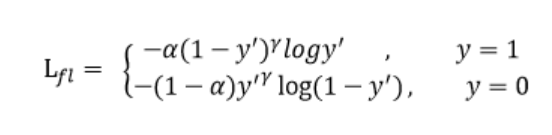

In [12]:
# ------------------------------------Loss Function--------------------------------------
def focal_loss_fixed(y_true, y_pred):
    alpha = 0.9
    gamma = 1.5
    # tensorflow backend, alpha and gamma are hyper-parameters which can set by you
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+ K.epsilon())) - K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))

def modified_binary_crossentropy(y_true, y_pred):
    alpha = 0.992
    return K.sum(-K.sum(alpha * y_true * K.log(K.clip(y_pred, 1e-10, 1.0)),axis=0,keepdims=True)-K.sum((1-alpha) * (1-y_true) * K.log(1.- K.clip(y_pred, 1e-10, 1.0)),axis=0,keepdims=True))



In [13]:
# ------------------------------------LSTM Model----------------------------------------
def build_model(inputs, output_size = output_size, neurons = neurons, activ_func = activation_function, drop_out = dropout, lamda = lamda, loss = loss, optimizer = optimizer):
    model = Sequential()
    model.add(SimpleRNN(neurons, input_shape = (inputs.shape[1],inputs.shape[2]), 
                   activity_regularizer=regularizers.l2(lamda),return_sequences=True, activation= activ_func,
                  kernel_constraint = MinMaxNorm(-50,50)))
    model.add(BatchNormalization())
    #model.add(LSTM(neurons, return_sequences=True, activation= activ_func,kernel_constraint = MinMaxNorm(-50,50)))
    #model.add(BatchNormalization())
    model.add(SimpleRNN(neurons,return_sequences=False,  activity_regularizer=regularizers.l2(lamda),activation= activ_func,
                   kernel_constraint = MinMaxNorm(-50,50)))
    model.add(BatchNormalization())
    model.add(Dense(output_size, activation = 'sigmoid',kernel_constraint = MinMaxNorm(-50,50)))
    optimizer = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
    model.compile(loss=modified_binary_crossentropy, optimizer='Adam', metrics = [tf_f1_score,tf_precision,tf_recall])
    model.summary()
    return model



In [14]:
# ------------------------------------Model Run----------------------------------------
x_train, y_train = label_dataset(train_filename)
print(x_train.shape,y_train.shape)
x_test, y_test = label_dataset(test_filename)
print(x_test.shape,y_test.shape)

(12078, 5, 3) (12078, 1)
(7518, 5, 3) (7518, 1)


In [15]:
hardware_failure_model = build_model(x_train, output_size = output_size, neurons = neurons)
hardware_history = hardware_failure_model.fit(x_train, y_train, epochs=20, batch_size=32, 
                                                    verbose=1, validation_data=(x_test,y_test), shuffle=True)


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 5, 32)             1152      
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 32)             128       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,521
Trainable params: 3,393
Non-trainable params: 128
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 12078 sam

# evaluation

## one_set_evaluation & plot 

In [16]:
def cut_first_period_data_test(data,boundary):
    label = np.where(data[:,1]>boundary)
    data = data[label[0][0]:data.shape[0]+1,:]
    return data
# --------------------------------Reshape Data(test)------------------------------------
def reshape_test(data, time_step_input = time_step_input):
    sample_num = data.shape[0]-time_step_input
    data_reshape = np.zeros((sample_num, time_step_input, data.shape[1]), dtype=np.float)
    for i in range(sample_num):
        for j in range(time_step_input):
            data_reshape[i,j] = data[i+j]
    return data_reshape
# --------------------------------Label Dataset(test)---------------------------------
def label_test_dataset(filename, time_step_input = time_step_input,predict_step = predict_step, feature_num = feature_num):
    dataset = read_csv(filename ,sep = ';', index_col = 0)
    dataset1 = prediction(dataset)
    data = dataset1.to_numpy()
    data = cut_first_period_data_test(data,89)
    data_reshape = reshape_test(data, time_step_input = time_step_input)
    timestamp1 = data_reshape[:,:,0:1]
    x_train1 = data_reshape[:,:,1:feature_num+1]
    label1 = data_reshape[:,:,4+1:4+predict_step+2]
    y_train1 = data_reshape[:,:,-1]
    label = np.zeros((label1.shape[0],label1.shape[2]))
    timestamp = np.zeros((timestamp1.shape[0],timestamp1.shape[2]))
    y_train = np.zeros((y_train1.shape[0],1))
    x_train = np.zeros((x_train1.shape[0],x_train1.shape[2]))
    for k in range(y_train1.shape[0]):
        y_train[k] = y_train1[k,-1]
        label[k] = label1[k,-1,:]
        timestamp[k] = timestamp1[k,-1,:]
        x_train[k] = x_train1[k,-1,:]
    for i in range(x_train1.shape[0]):
        normalization(x_train1[i])
    return  x_train1, y_train, timestamp, label, x_train, dataset

In [18]:
x_test, y_test, timestamp, label, feature, dataset= label_test_dataset(filename[27])
y = hardware_failure_model.predict(x_test)

In [19]:
# -----------------------Evaluation(Self_defined_recall&precision)------------------
boundary = 0.90
def precision_self(y_true, y_pred,boundary = boundary):	
    """Precision metric.	
    Only computes a batch-wise average of precision. Computes the precision, a
    metric for multi-label classification of how many selected items are
    relevant.
    """	
    true_positives = np.sum(np.where((np.clip(y_true * y_pred, 0, 1))>boundary,1,0))
    print(true_positives)
    predicted_positives = np.sum(np.where((np.clip(y_pred, 0, 1))>0.7,1,0))	
    print(predicted_positives)
    precision = true_positives / (predicted_positives + 1e-07)	
    return precision

def recall_self(y_true, y_pred,boundary = boundary):	
    """Recall metric.	
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """	
    true_positives = np.sum(np.where((np.clip(y_true * y_pred, 0, 1))>boundary,1,0))	
    possible_positives = np.sum(np.where((np.clip(y_true, 0, 1))>boundary,1,0))	
    recall = true_positives / (possible_positives +  1e-07)	
    return recall

def f1_score_self(y_true, y_pred):
    """Computes the F1 Score
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """
    p = precision_self(y_true, y_pred)
    r = recall_self(y_true, y_pred)
    return (2 * p * r) / (p + r + 1e-07)

In [20]:
precision_value = precision_self(y_test, y)
recall_value = recall_self(y_test, y)
f1_score_value = f1_score_self(y_test, y)
print(precision_value, recall_value, f1_score_value)
print(y_test.shape, y.shape)

5
19
5
19
0.26315789335180056 0.9999999800000003 0.4166666302083356
(809, 1) (809, 1)


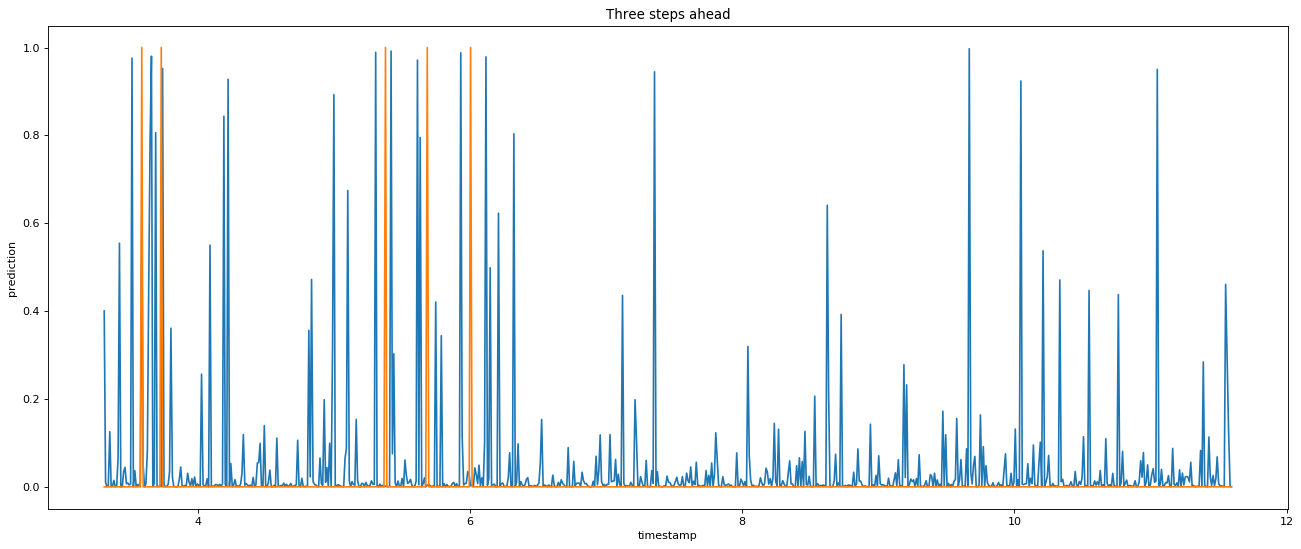

In [21]:
plt.figure(figsize=(20,8),dpi=80)
plt.title("Three steps ahead") 
plt.xlabel("timestamp") 
plt.ylabel("prediction ") 
plt.plot(timestamp,y)
plt.plot(timestamp,label[:,0])
plt.show()

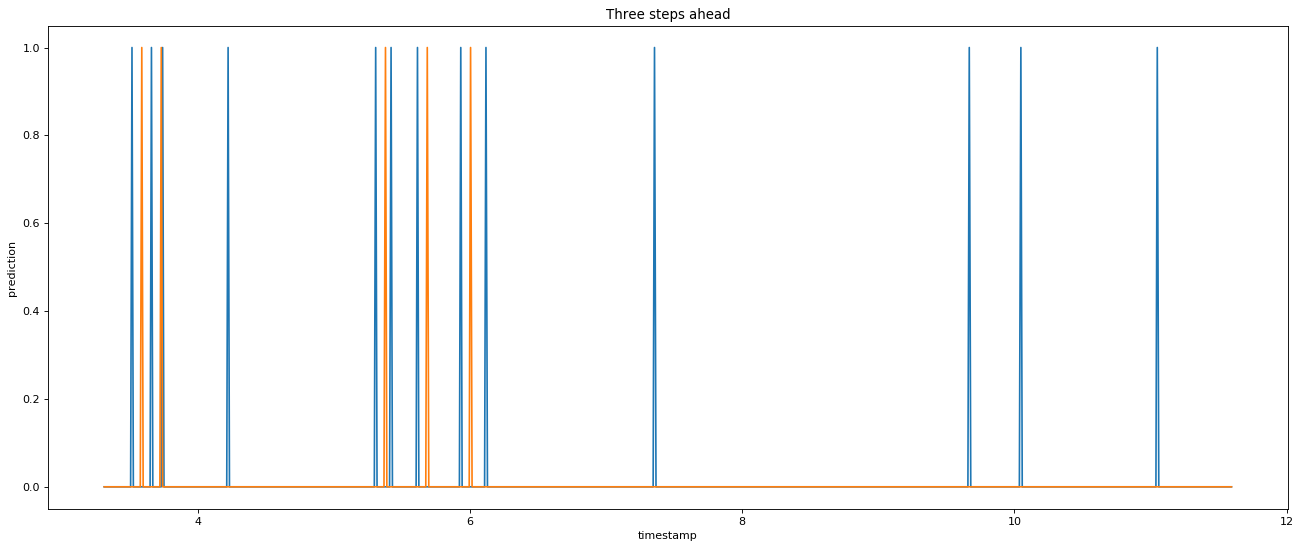

In [22]:
#------------plot post process data----------------------
y_clip = np.where((np.clip(y, 0, 1))>boundary,1,0)
plt.figure(figsize=(20,8),dpi=80)
plt.title("Three steps ahead") 
plt.xlabel("timestamp") 
plt.ylabel("prediction ") 
plt.plot(timestamp,y_clip)
plt.plot(timestamp,label[:,0])
plt.show()

## multiple set evaluation

--------sklearn F1-score recall precision--------------

In [23]:
x_validation, y_validation = label_dataset(filename)
y_predict = hardware_failure_model.predict(x_validation)

In [24]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_validation[:,0], y_predict[:,0])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.77


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.77')

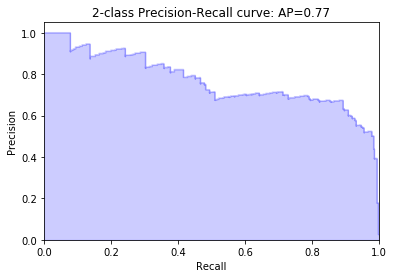

In [25]:
from sklearn.metrics import precision_recall_curve
from inspect import signature

precision, recall, _ = precision_recall_curve(y_validation,  y_predict)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

---------------------------------end------------------------------------------

In [80]:
hardware_failure_model.save_weights('hardware_failure_model_best3_bitconstraint_decimal3_7steps_alpha0992_timestep5_neuron64_0dropout_0L2.h5')

In [ ]:
#hardware_failure_model.load_weights('hardware_failure_model1.h5')